In [1]:
import fenics as f
import festim as F
import matplotlib.pyplot as plt
from models import velocity_field, transient_t_transport_sim, mesh_2d, load_xdmf_mesh
import numpy as np
import scipy
import h_transport_materials as htm

----------  Running for dT=2 K  ----------*** Warning: Matplotlib plotting backend does not support mesh function of dim 1. Continuing without plotting...

Running for factor=1.0e-03
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
Running for factor=1.0e-02  Newton iteration 0: r (abs) = 5.248e+04 (tol = 1.000e-09) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 4.580e-05 (tol = 1.000e-09) r (rel) = 8.728e-10 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
Running for factor=1.0e-01  Newton iteration 0: r (abs) = 4.580e-05 (tol = 1.000e-09) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 9.450e-05 (tol = 1.000e-09) r (rel) = 2.063e+

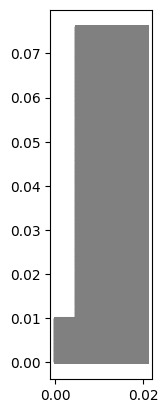

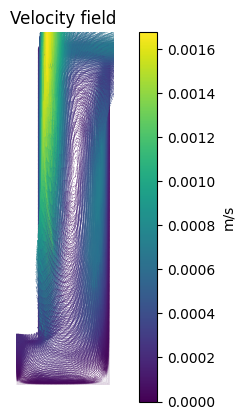

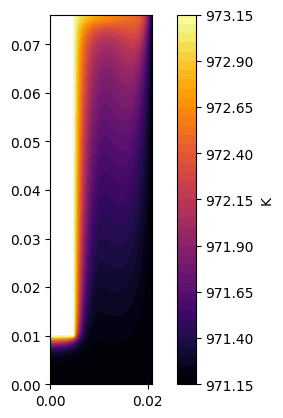

In [2]:
# Generating mesh
# x1 = 0.00476
# x2 = 0.0162
# y1 = 0.01
# y2 = 0.0761
# resolution = 30
# mesh_fenics, surface_markers, left_id, top_id, right_id, bottom_id, upper_left_id, left_top_id = LMeshmshr(x1, x2, y1, y2, resolution)

# mesh_fenics, volume_markers, surface_markers, correspondance_dict = mesh_2d()

load_mesh_model = F.Simulation()
load_mesh_model.mesh = F.MeshFromXDMF(volume_file="ImportedMesh/mesh_domains.xdmf", boundary_file="ImportedMesh/mesh_boundaries.xdmf")
mesh_fenics, volume_markers, surface_markers, correspondance_dict = load_xdmf_mesh("ImportedMesh/")

T_hot = 700 + 273.15
dT = 2
T_cold = T_hot - dT

print(f"----------  Running for dT={dT} K  ----------")
foldername = f"Results_Transient/dt={dT}/"
u, p, T = velocity_field(
    T_cold=T_cold,
    T_hot=T_hot,
    my_mesh=mesh_fenics,
    surface_markers=surface_markers,
    correspondance_dict=correspondance_dict,
)

f.XDMFFile(foldername + "temperature_field.xdmf").write_checkpoint(
    T, f"{foldername}temperature", 1, f.XDMFFile.Encoding.HDF5
)
f.XDMFFile(foldername + "velocity_field.xdmf").write(u)

plt.figure()
plt.title("Velocity field")
CS = f.plot(u, scale=1e-3)
plt.colorbar(CS, label="m/s")
plt.axis("off")
plt.show()

plt.figure()
TS = f.plot(T, cmap="inferno")
plt.colorbar(TS, label="K")
plt.show()


Salt volume : 0.00010032583902078721 m3, 100.32583902078721 mL
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/Users/colinweaver/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:52: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


100.0 %        6.0e+05 s    Ellapsed time so far: 16.4 s


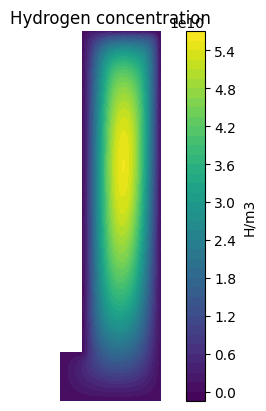

In [3]:
diffusivities = htm.diffusivities.filter(material="flibe").filter(author=["nakamura", "anderl"])

top_flux_array = []
wall_flux_array = []
for diffusivity in diffusivities:
    top_flux, wall_flux, total_volume, t = transient_t_transport_sim(
        T,
        mesh_fenics,
        u,
        volume_markers=volume_markers,
        surface_markers=surface_markers,
        correspondance_dict=correspondance_dict,
        D_0 = diffusivity.pre_exp.magnitude, 
        E_D = diffusivity.act_energy.magnitude
    )   
    top_flux_array.append(top_flux)
    wall_flux_array.append(wall_flux)

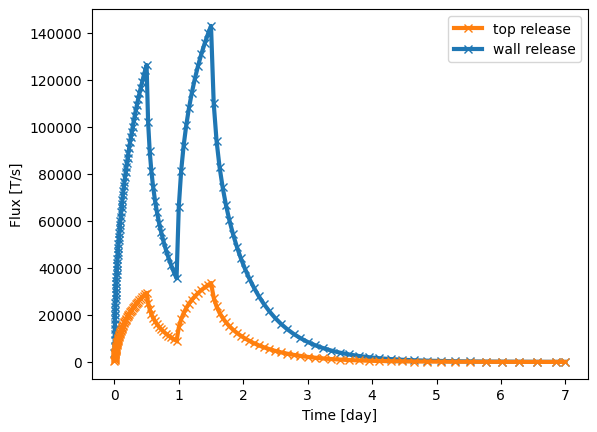

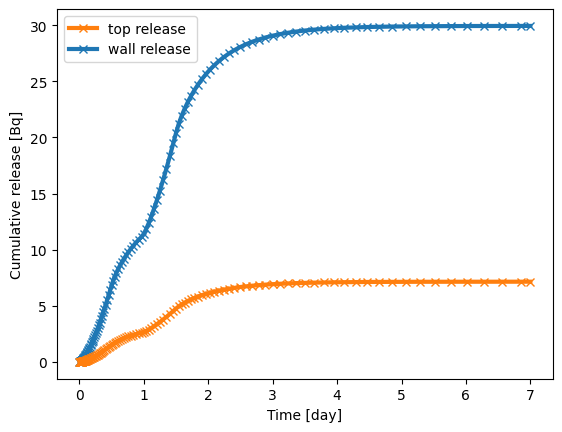

In [4]:
tritium_specific_activity = 3.57e14  # Bq/g
tritium_molar_mass = 3.016  # g/mol
avogadro_number = 6.022e23  # mol^-1

def quantity_to_activity(quantity):
    return quantity * tritium_molar_mass * tritium_specific_activity / avogadro_number

s_to_day = 1 / 60 / 60 / 24
t = np.array(t)
plt.figure()
for i in range(len(wall_flux_array)):
    plt.subplot(2, 1, 1)
    top_flux = top_flux_array[i]
    wall_flux = wall_flux_array[i]

    plt.plot(t * s_to_day, wall_flux, "-x", linewidth=3, label="wall release")
    plt.plot(t * s_to_day, top_flux, "-x", linewidth=3, label="top release")
    plt.ylabel("Flux [T/s]")
    plt.xlabel("Time [day]")
    plt.legend(reverse=True)

    wall_release = scipy.integrate.cumulative_trapezoid(wall_flux, t, initial=0)
    top_release = scipy.integrate.cumulative_trapezoid(top_flux, t, initial=0)

    plt.subplot(2, 1, 2)
    plt.plot(t* s_to_day, quantity_to_activity(wall_release), "-x", linewidth=3, label="wall release")
    plt.plot(t* s_to_day, quantity_to_activity(top_release), "-x", linewidth=3, label="top release")
    plt.ylabel("Cumulative release [Bq]")
    plt.xlabel("Time [day]")
    # plt.ylim(0, 35)
    plt.legend(reverse=True)
plt.show()

In [5]:
measured_tritium_source = 1.83e5  # T/s

twelve_hr = 12 * 3600

expected_activity = quantity_to_activity(measured_tritium_source * 2 * twelve_hr)
computed_activity = quantity_to_activity(wall_release[-1] + top_release[-1] + total_volume[-1])

print(f"Expected activity: {expected_activity:.2f} Bq")
print(f"Computed activity: {computed_activity:.2f} Bq")
print(f"Total in salt at the end {total_volume[-1]:.2e} T, {quantity_to_activity(total_volume[-1]):.2e} Bq")

Expected activity: 28.27 Bq
Computed activity: 37.09 Bq
Total in salt at the end 2.40e+06 T, 4.28e-03 Bq
